In [104]:
import json
from glob import glob
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

In [109]:
def create_img(path, total):
    img = Image.open(path, 'r')
    
    img1 = ImageDraw.Draw(img)
    img1.line([(1400, 450), (10, 400)], fill=(255, 255, 255), width = 15)
    img1.line([(1400, 450), (10, 400)], fill=(0, 0, 0), width = 5)
#     img1.line([(1150, 550), (1000, 910)], fill=(255, 255, 255), width = 15) 
#     img1.line([(1150, 550), (1000, 910)], fill=(0, 0, 0), width = 5)
    
    
    font = ImageFont.truetype('Helvetica.ttf', 30) 
    
    status = '{0:.0f} || {1:.0f}'.format(total[0], total[1])
    img1.text((650+10, 300+10), status, font=font, align ="left", fill=(255, 255, 255))
    img = img.crop((650, 300, 1600, 920))
    
    
    
    return img

In [110]:
print(glob('full_on_pwc/dam_results*'))

frames = glob('data/Dam/test_video/*')
frames.sort()

['full_on_pwc/dam_results2.json', 'full_on_pwc/dam_results1.json']


In [111]:
json_path = 'full_on_pwc/dam_results1.json'
with open(json_path) as json_file:
    data = json.load(json_file)

total = [0.0, 0.0]
for i, (l, r) in enumerate(zip(data['per_frame'][0], data['per_frame'][1])):
    if r < 1e-4:
        r = 0
    
    if l < 1e-4:
        l = 0
    
    total[0] += l
    total[1] += r
    
    img = create_img(frames[i], total)
    img.save('cropped_imgs/{:05d}.png'.format(i))
    
    if (i+1)%20 == 0:
        print(i)
        print('{0:.0f} | {1:.0f}'.format(total[0], total[1]))


19
0 | 0
39
2 | 3
59
2 | 3
79
2 | 3
99
2 | 3
119
2 | 3
139
2 | 3
159
2 | 3
179
2 | 3
199
2 | 3
219
2 | 3
239
2 | 3
259
2 | 3
279
2 | 6
299
2 | 9
319
6 | 9
339
6 | 9
359
6 | 9
379
6 | 9
399
6 | 9
419
6 | 9
439
6 | 9
459
6 | 9
479
6 | 13
499
6 | 13
519
6 | 13
539
6 | 13
559
6 | 13
579
6 | 14
599
6 | 14
619
6 | 18
639
6 | 18
659
6 | 18
679
6 | 18
699
6 | 20
719
6 | 20
739
6 | 20
759
10 | 20
779
10 | 20
799
10 | 20
819
13 | 20
839
13 | 20
859
13 | 20
879
13 | 20
899
13 | 22
919
13 | 22
939
13 | 22
959
13 | 22
979
13 | 23
999
13 | 24
1019
13 | 24
1039
13 | 24
1059
13 | 24
1079
13 | 24
1099
13 | 24
1119
13 | 24
1139
13 | 24
1159
13 | 24
1179
13 | 24
1199
14 | 26
1219
14 | 26
1239
14 | 29
1259
18 | 29
1279
18 | 29
1299
19 | 30
1319
23 | 30
1339
23 | 30
1359
23 | 30
1379
23 | 30
1399
23 | 30
1419
23 | 30
1439
23 | 30
1459
23 | 30
1479
23 | 30
1499
24 | 30
1519
26 | 30
1539
26 | 32
1559
26 | 35
1579
26 | 35
1599
26 | 35
1619
26 | 35
1639
26 | 35
1659
26 | 35
1679
26 | 35
1699
26 | 35
1719
26 | 

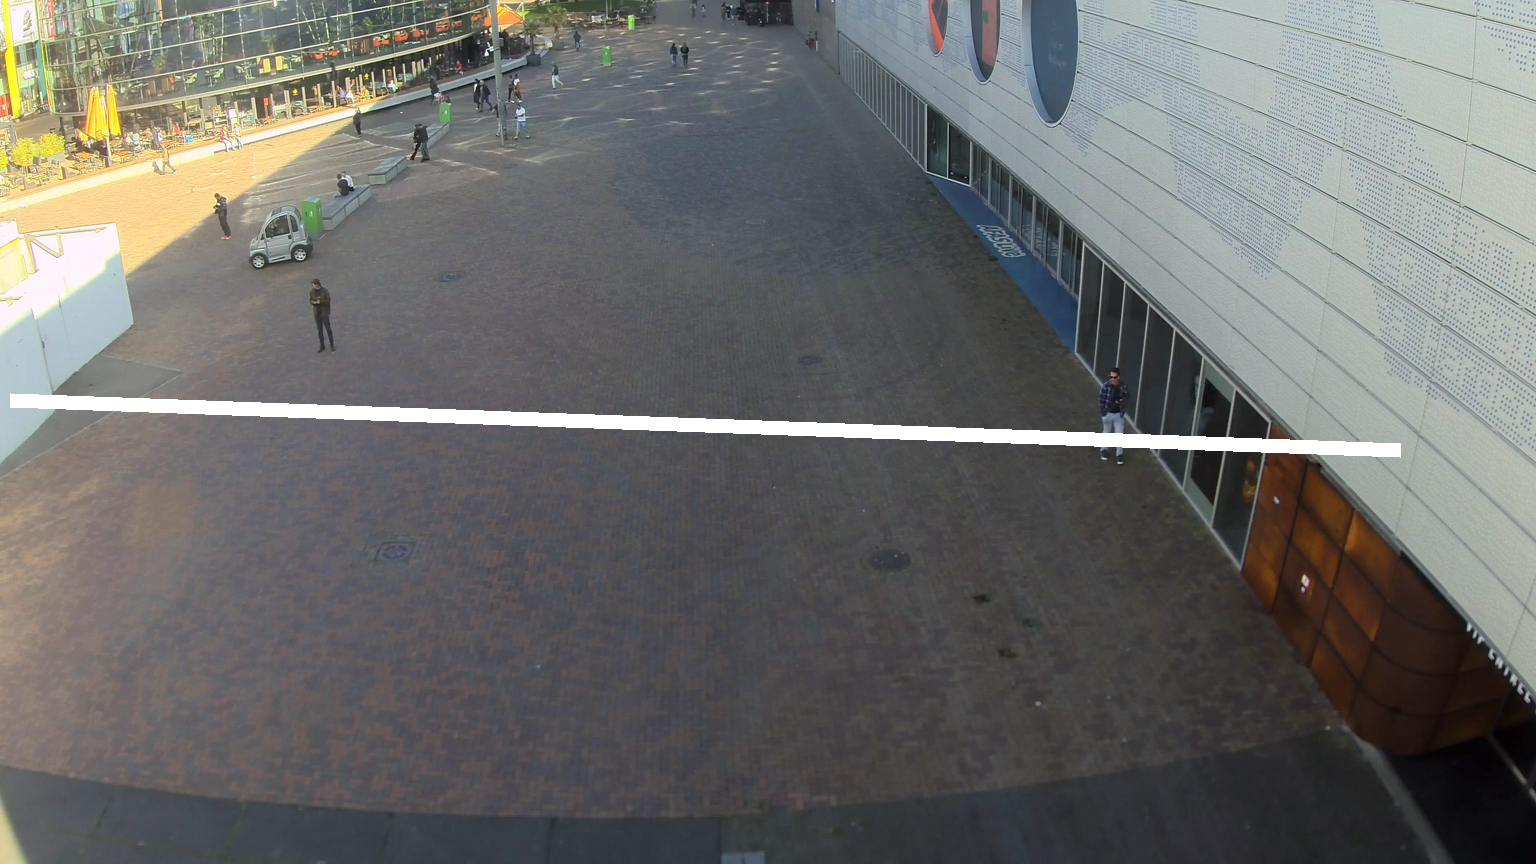

In [117]:
frames = glob('data/Dam/test_arena/*')
img = Image.open(frames[0], 'r')

img1 = ImageDraw.Draw(img)
img1.line([(1400, 450), (10, 400)], fill=(255, 255, 255), width = 15)
# img1.line([(1150, 550), (1000, 910)], fill=(255, 255, 255), width = 15) 

display(img)

In [103]:
import ffmpeg
ffmpeg.input('cropped_imgs/*', pattern_type='glob', framerate=5).output('movie.mp4').run()

ModuleNotFoundError: No module named 'ffmpeg'